In [18]:
%matplotlib inline

import numpy as np
import healpy as hp
import imageio
import matplotlib.pyplot as plt

from jax import jit, config, grad
config.update("jax_enable_x64", True)

import scatcovjax.plotting as plot
import scatcovjax.Sphere_lib as sphlib

import s2fft

In [11]:
#path_h5file = '/home/lmousset/PycharmProjects/scatcovJAX/texture_maps/'

In [12]:
# import h5py
# hf = h5py.File(path_h5file+'projected_probes_maps_baryonified512.h5', 'r')
# print(hf.keys())
# # data = hf['ia']
# data = hf.get('kg/stage3_lensing2')
# # data = f.get(path_h5file+'projected_probes_maps_nobaryons512.h5')
# map_hp = np.array(data)

In [13]:
# print(map_hp)
# mu = np.mean(map_hp)
# hp.mollview(map_hp, cmap='viridis', norm='hist')

# Raw data Nside=512

In [14]:
data = np.load('/home/lmousset/PycharmProjects/scatcovJAX/texture_maps/baryonified_shells.npz')
print(data['shell_info'])

[('CosmoML-shell_z-high=0.6627892_z-low=0.6339825.fits', 34, 0.6339825 , 0.6627892 , 1645.3431 , 1707.9154 , 1676.7548  )
 ('CosmoML-shell_z-high=0.6925908_z-low=0.6627892.fits', 35, 0.6627892 , 0.6925908 , 1707.9154 , 1771.6001 , 1739.8901  )
 ('CosmoML-shell_z-high=0.6339825_z-low=0.6061132.fits', 33, 0.6061132 , 0.6339825 , 1583.8463 , 1645.3431 , 1614.7136  )
 ('CosmoML-shell_z-high=0.7234494_z-low=0.6925908.fits', 36, 0.6925908 , 0.7234494 , 1771.6001 , 1836.4359 , 1804.1578  )
 ('CosmoML-shell_z-high=0.7554329_z-low=0.7234494.fits', 37, 0.7234494 , 0.7554329 , 1836.4359 , 1902.4641 , 1869.5978  )
 ('CosmoML-shell_z-high=0.7886154_z-low=0.7554329.fits', 38, 0.7554329 , 0.7886154 , 1902.4641 , 1969.729  , 1936.2529  )
 ('CosmoML-shell_z-high=0.823078_z-low=0.7886154.fits', 39, 0.7886154 , 0.823078  , 1969.729  , 2038.2778 , 2004.1688  )
 ('CosmoML-shell_z-high=0.8589094_z-low=0.823078.fits', 40, 0.823078  , 0.8589094 , 2038.2778 , 2108.1604 , 2073.3943  )
 ('CosmoML-shell_z-high=0.

In [20]:
i = 40 # 0 to 68
map_hp = data['shells'][i, :]
map_info = data['shell_info'][i]

shell_id = map_info[1]
print('Shell ID:', shell_id)

lower_z = map_info[2]
upper_z = map_info[3]
z = (lower_z + upper_z) / 2

Shell ID: 13


In [36]:
print(np.min(map_hp), np.max(map_hp))


0.0 8652.74085527136


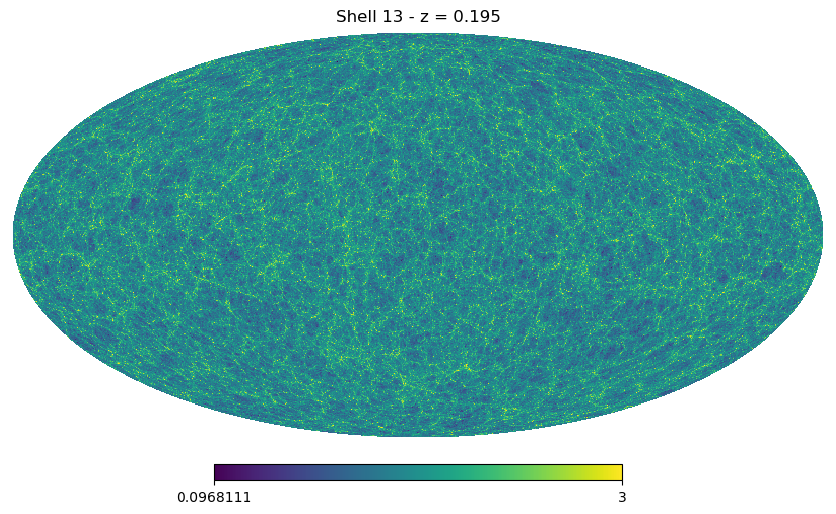

In [37]:

# map_hp -= np.nanmean(map_hp)
# map_hp /= np.nanstd(map_hp)
hp.mollview(np.log10(map_hp), cmap='viridis', title=f'Shell {shell_id} - z = {z:.3f}', max=3)

In [31]:
np.sum(np.isnan(np.log10(map_hp)))

0

# Make a Gif with all images as a function of z

In [13]:
# for i in range(69):
#     map_hp = data['shells'][i, :]
#     map_info = data['shell_info'][i]
#
#     # Maps are not stored in the ID order for the baryonified set
#     shell_id = map_info[1]
#
#     lower_z = map_info[2]
#     upper_z = map_info[3]
#     z = (lower_z + upper_z) / 2
#
#     hp.mollview(map_hp, cmap='viridis', norm='hist', title=f'Shell {shell_id} - z = {z:.3f}')
#
#     plt.savefig(f'/home/lmousset/Desktop/img_Shell{shell_id}.png',
#                 transparent = False,
#                 facecolor = 'white'
#                )

In [9]:
# frames = []
# for shell_id in range(69):
#     image = imageio.v2.imread(f'/home/lmousset/Desktop/img_Shell{shell_id}.png')
#     frames.append(image)

In [10]:
# imageio.mimsave('/home/lmousset/Desktop/simu_shells_baryon_nside=512.gif', # output gif
#                 frames,          # array of input frames
#                 fps = 1)         # optional: frames per second

# Get MW alm for the synthesis

In [59]:
i = 40 # 0 to 68
map_hp = data['shells'][i, :]
map_info = data['shell_info'][i]
shell_id = map_info[1]

# map_hp = np.log10(map_hp)

L = 512
lmax = L - 1
# pixel weights et iter ??
flm_hp = hp.map2alm(map_hp, lmax=lmax, iter=3, use_pixel_weights=False)

print(flm_hp.shape)

(131328,)


In [60]:
# Make a 2D array
flm_MW = s2fft.samples.flm_hp_to_2d(flm_hp, L)  # [L, 2L-1]
print(flm_MW.shape)

# As the map is real, we only keep the m>=0
flm_MW = flm_MW[:, L-1:]  # [L, L]
print(flm_MW.shape)

(512, 1023)
(512, 512)


In [61]:
# Make a MW map
map_MW = s2fft.inverse_jax(flm_MW, L, reality=True)

In [77]:
# map_MW -= np.nanmean(map_MW)
# map_MW /= np.nanstd(map_MW)

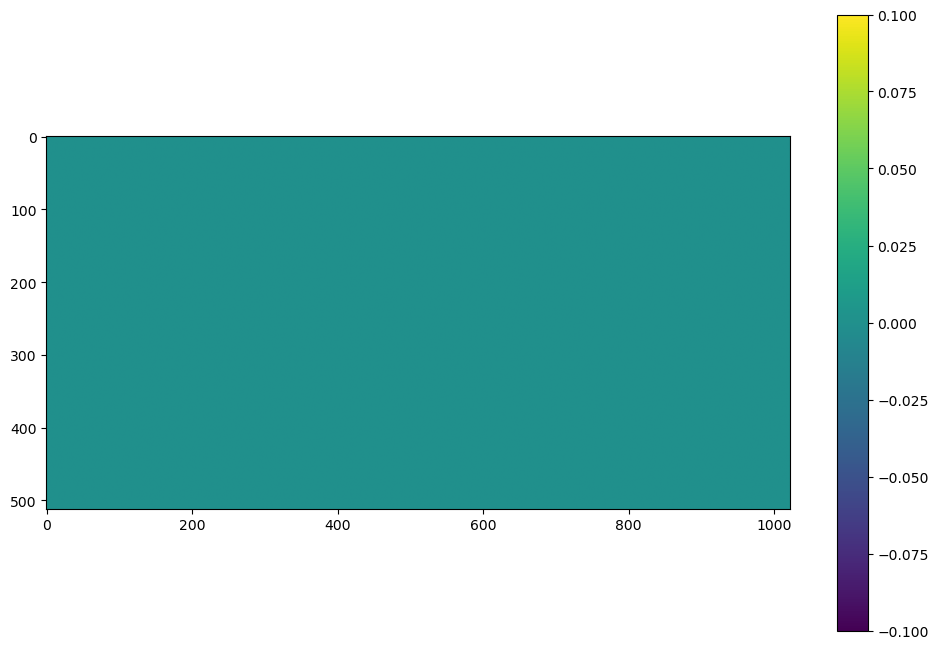

In [58]:
plt.figure(figsize=(12, 8))
plt.imshow(map_MW, cmap='viridis')
plt.colorbar()

In [25]:
I, Ilm = sphlib.make_MW_lensing(L, reality=True, normalize=True)

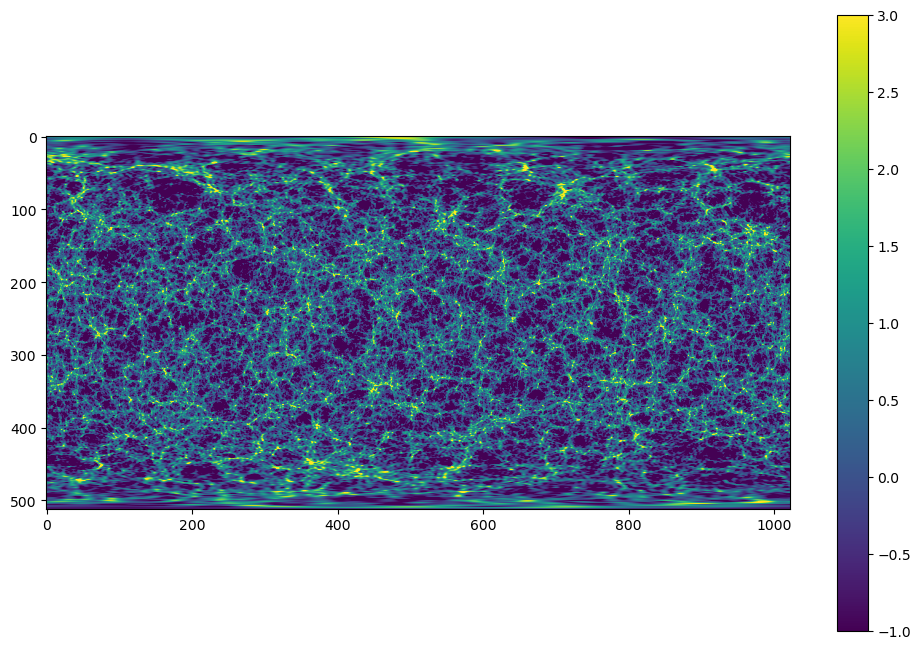

In [26]:
plt.figure(figsize=(12, 8))
plt.imshow(I, cmap='viridis', vmin=-1, vmax=3)
plt.colorbar()

In [27]:
np.min(I)

-3.057005580953515

In [108]:
0.23*3

0.6900000000000001